How does survival probability work for independent variables?
The model so far just shows an average.
If it always starts at day 1, how does it adjust for signs coming at different points???

In [81]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from lifelines import KaplanMeierFitter, NelsonAalenFitter, CoxPHFitter
from lifelines.statistics import logrank_test
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn import metrics
from sklearn.metrics import classification_report, f1_score

#from cm import plot_confusion_matrix

In [3]:
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 100)
pd.set_option('display.width', 1000)

In [4]:
data = pd.read_csv('../data/lung.csv')

In [5]:
data.head()

,Unnamed: 0,inst,time,status,age,sex,ph.ecog,ph.karno,pat.karno,meal.cal,wt.loss
0,1,3.0,306,2,74,1,1.0,90.0,100.0,1175.0,NaN
1,2,3.0,455,2,68,1,0.0,90.0,90.0,1225.0,15.0
2,3,3.0,1010,1,56,1,0.0,90.0,90.0,NaN,15.0
3,4,5.0,210,2,57,1,1.0,90.0,60.0,1150.0,11.0
4,5,1.0,883,2,60,1,0.0,100.0,90.0,NaN,0.0


In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 228 entries, 0 to 227
Data columns (total 11 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Unnamed: 0  228 non-null    int64  
 1   inst        227 non-null    float64
 2   time        228 non-null    int64  
 3   status      228 non-null    int64  
 4   age         228 non-null    int64  
 5   sex         228 non-null    int64  
 6   ph.ecog     227 non-null    float64
 7   ph.karno    227 non-null    float64
 8   pat.karno   225 non-null    float64
 9   meal.cal    181 non-null    float64
 10  wt.loss     214 non-null    float64
dtypes: float64(6), int64(5)
memory usage: 19.7 KB


In [7]:
data.describe()

,Unnamed: 0,inst,time,status,age,sex,ph.ecog,ph.karno,pat.karno,meal.cal,wt.loss
count,228.00000,227.000000,228.000000,228.000000,228.000000,228.000000,227.000000,227.000000,225.000000,181.000000,214.000000
mean,114.50000,11.088106,305.232456,1.723684,62.447368,1.394737,0.951542,81.938326,79.955556,928.779006,9.831776
std,65.96211,8.303491,210.645543,0.448159,9.073457,0.489870,0.717872,12.327955,14.623177,402.174707,13.139902
min,1.00000,1.000000,5.000000,1.000000,39.000000,1.000000,0.000000,50.000000,30.000000,96.000000,-24.000000
25%,57.75000,3.000000,166.750000,1.000000,56.000000,1.000000,0.000000,75.000000,70.000000,635.000000,0.000000
50%,114.50000,11.000000,255.500000,2.000000,63.000000,1.000000,1.000000,80.000000,80.000000,975.000000,7.000000
75%,171.25000,16.000000,396.500000,2.000000,69.000000,2.000000,1.000000,90.000000,90.000000,1150.000000,15.750000
max,228.00000,33.000000,1022.000000,2.000000,82.000000,2.000000,3.000000,100.000000,100.000000,2600.000000,68.000000


In [13]:
# Create kmf object
kmf = KaplanMeierFitter()

In [14]:
data.loc[data.status == 1, 'dead'] = 0
data.loc[data.status == 2, 'dead'] = 1

data.head()

,Unnamed: 0,inst,time,status,age,sex,ph.ecog,ph.karno,pat.karno,meal.cal,wt.loss,dead
0,1,3.0,306,2,74,1,1.0,90.0,100.0,1175.0,NaN,1.0
1,2,3.0,455,2,68,1,0.0,90.0,90.0,1225.0,15.0,1.0
2,3,3.0,1010,1,56,1,0.0,90.0,90.0,NaN,15.0,0.0
3,4,5.0,210,2,57,1,1.0,90.0,60.0,1150.0,11.0,1.0
4,5,1.0,883,2,60,1,0.0,100.0,90.0,NaN,0.0,1.0


In [15]:
# The 1st arg accepts an array or pd.Series of individual survival times
# The 2nd arg accepts an array or pd.Series that indicates if the event
# interest (or death) occured.

kmf.fit(durations = data['time'], event_observed = data['dead'])

<lifelines.KaplanMeierFitter:"KM_estimate", fitted with 228 total observations, 63 right-censored observations>

In [16]:
kmf.event_table

,removed,observed,censored,entrance,at_risk
event_at,,,,,
0.0,0,0,0,228,228
5.0,1,1,0,0,228
11.0,3,3,0,0,227
12.0,1,1,0,0,224
13.0,2,2,0,0,223
...,...,...,...,...,...
840.0,1,0,1,0,5
883.0,1,1,0,0,4
965.0,1,0,1,0,3


In [18]:
# Calulating survival probability by hand:
event_at_0 = kmf.event_table.iloc[0,:]

# Calculate the survival probability for t=0
surv_for_0 = (event_at_0.at_risk - event_at_0.observed)/event_at_0.at_risk
surv_for_0

1.0

In [20]:
# Calulating survival probability by hand:
event_at_5 = kmf.event_table.iloc[1,:]

# Calculate the survival probability for t=0
surv_for_5 = (event_at_5.at_risk - event_at_5.observed)/event_at_5.at_risk
surv_for_5

0.9956140350877193

In [21]:
# Calulating survival probability by hand:
event_at_11 = kmf.event_table.iloc[2,:]

# Calculate the survival probability for t=0
surv_for_11 = (event_at_11.at_risk - event_at_11.observed)/event_at_11.at_risk
surv_for_11

0.986784140969163

In [22]:
# We want to find the survival probability of all phases of survival
# Basically, a multiplication of the above answers, for entire lifetime of study

# Predict through 11 days
kmf.predict(11)

0.9824561403508766

In [23]:
# As an array
kmf.predict([0, 5, 11, 12])

0     1.000000
5     0.995614
11    0.982456
12    0.978070
Name: KM_estimate, dtype: float64

In [25]:
# of Full timeline
kmf.survival_function_

,KM_estimate
timeline,
0.0,1.000000
5.0,0.995614
11.0,0.982456
12.0,0.978070
13.0,0.969298
...,...
840.0,0.067127
883.0,0.050346
965.0,0.050346


In [26]:
# prediction of when on average, 50% of patients will have died:
kmf.median_survival_time_

310.0

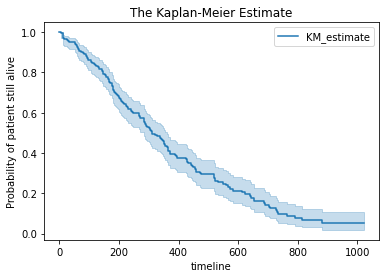

In [27]:
# Plot the graph:

kmf.plot()
plt.title("The Kaplan-Meier Estimate")
plt.ylabel("Probability of patient still alive")
plt.show()

In [28]:
kmf.confidence_interval_

,KM_estimate_lower_0.95,KM_estimate_upper_0.95
0.0,1.000000,1.000000
5.0,0.969277,0.999381
11.0,0.953935,0.993379
12.0,0.948120,0.990813
13.0,0.936682,0.985244
...,...,...
840.0,0.030728,0.123060
883.0,0.017866,0.108662
965.0,0.017866,0.108662
1010.0,0.017866,0.108662


In [30]:
# chance of survival:
kmf.cumulative_density_

,KM_estimate
timeline,
0.0,0.000000
5.0,0.004386
11.0,0.017544
12.0,0.021930
13.0,0.030702
...,...
840.0,0.932873
883.0,0.949654
965.0,0.949654


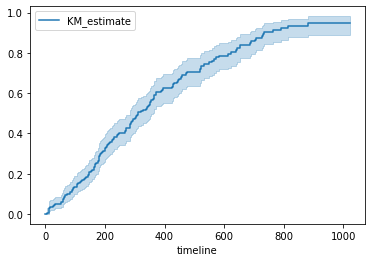

In [31]:
kmf.plot_cumulative_density();

## Hazard Rates using Nelson-Aalen

In [33]:
naf = NelsonAalenFitter()

In [34]:
naf.fit(data['time'], event_observed = data['dead'])

<lifelines.NelsonAalenFitter:"NA_estimate", fitted with 228 total observations, 63 right-censored observations>

In [35]:
naf.cumulative_hazard_

,NA_estimate
timeline,
0.0,0.000000
5.0,0.004386
11.0,0.017660
12.0,0.022125
13.0,0.031114
...,...
840.0,2.641565
883.0,2.891565
965.0,2.891565


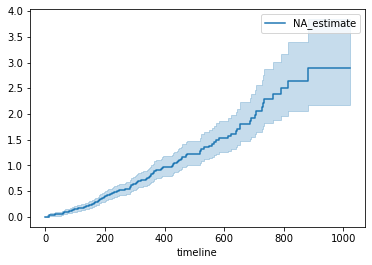

In [36]:
naf.plot_cumulative_hazard()

In [41]:
# Predict value of certain point:
naf.predict(1022)

2.8915648373471052

## Kaplan-Meier fitter based on different groups

In [43]:
data.head()

,Unnamed: 0,inst,time,status,age,sex,ph.ecog,ph.karno,pat.karno,meal.cal,wt.loss,dead
0,1,3.0,306,2,74,1,1.0,90.0,100.0,1175.0,NaN,1.0
1,2,3.0,455,2,68,1,0.0,90.0,90.0,1225.0,15.0,1.0
2,3,3.0,1010,1,56,1,0.0,90.0,90.0,NaN,15.0,0.0
3,4,5.0,210,2,57,1,1.0,90.0,60.0,1150.0,11.0,1.0
4,5,1.0,883,2,60,1,0.0,100.0,90.0,NaN,0.0,1.0


In [44]:
# Create male and female objects for kmf fitter

kmf_m = KaplanMeierFitter()
kmf_f = KaplanMeierFitter()

In [45]:
Male = data.query('sex==1')
Female = data.query('sex == 2')

In [47]:
#Fit data into our objects
# 1st argument is series/array of survival times
# 2nd argument indicuates whether death event ocurred

kmf_m.fit(durations = Male['time'], event_observed = Male['dead'], label = 'Male')
kmf_f.fit(durations = Female['time'], event_observed = Female['dead'], label = 'Female')

<lifelines.KaplanMeierFitter:"Female", fitted with 90 total observations, 37 right-censored observations>

In [48]:
kmf_m.event_table

,removed,observed,censored,entrance,at_risk
event_at,,,,,
0.0,0,0,0,138,138
11.0,3,3,0,0,138
12.0,1,1,0,0,135
13.0,2,2,0,0,134
15.0,1,1,0,0,132
...,...,...,...,...,...
814.0,1,1,0,0,5
840.0,1,0,1,0,4
883.0,1,1,0,0,3


In [49]:
kmf_f.event_table

,removed,observed,censored,entrance,at_risk
event_at,,,,,
0.0,0,0,0,90,90
5.0,1,1,0,0,90
60.0,1,1,0,0,89
61.0,1,1,0,0,88
62.0,1,1,0,0,87
79.0,1,1,0,0,86
81.0,1,1,0,0,85
92.0,1,0,1,0,84
95.0,1,1,0,0,83


In [50]:
kmf_m.predict(11)

0.9782608695652172

In [52]:
kmf_f.predict(11)

0.9888888888888887

In [53]:
kmf_m.survival_function_

,Male
timeline,
0.0,1.000000
11.0,0.978261
12.0,0.971014
13.0,0.956522
15.0,0.949275
...,...
814.0,0.053571
840.0,0.053571
883.0,0.035714


In [54]:
kmf_f.survival_function_

,Female
timeline,
0.0,1.000000
5.0,0.988889
60.0,0.977778
61.0,0.966667
62.0,0.955556
79.0,0.944444
81.0,0.933333
92.0,0.933333
95.0,0.922088


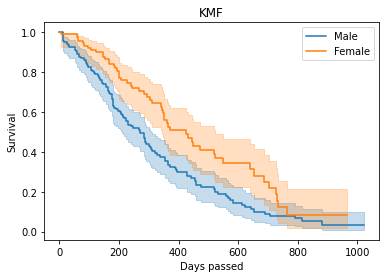

In [63]:
kmf_m.plot()
kmf_f.plot()

plt.xlabel('Days passed')
plt.ylabel('Survival')
plt.title('KMF');

In [64]:
# Probability of someone dying at a certain timeline

kmf_m.cumulative_density_

,Male
timeline,
0.0,0.000000
11.0,0.021739
12.0,0.028986
13.0,0.043478
15.0,0.050725
...,...
814.0,0.946429
840.0,0.946429
883.0,0.964286


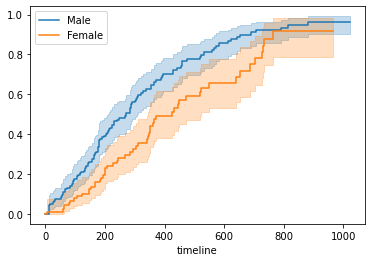

In [65]:
kmf_m.plot_cumulative_density()
kmf_f.plot_cumulative_density()

### Hazard Function

In [66]:
naf_m = NelsonAalenFitter()
naf_f = NelsonAalenFitter()

naf_m.fit(Male['time'], event_observed = Male['dead'])
naf_f.fit(Female['time'], event_observed = Female['dead'])

<lifelines.NelsonAalenFitter:"NA_estimate", fitted with 90 total observations, 37 right-censored observations>

In [67]:
naf_m.cumulative_hazard_

,NA_estimate
timeline,
0.0,0.000000
11.0,0.021899
12.0,0.029306
13.0,0.044287
15.0,0.051863
...,...
814.0,2.831337
840.0,2.831337
883.0,3.164670


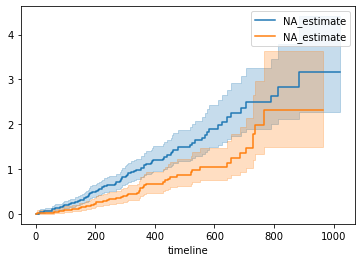

In [69]:
naf_m.plot_cumulative_hazard()
naf_f.plot_cumulative_hazard()

## Log-Rank Test

In [71]:
T = Male['time']
E = Male['dead']
T1 = Female['time']
E1= Female['dead']

In [72]:
results = logrank_test(T, T1, event_observed_A=E, event_observed_B=E1)
results.print_summary()

<lifelines.StatisticalResult: logrank_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 1
         test_name = logrank_test

---
 test_statistic      p  -log2(p)
          10.33 <0.005      9.57

Here we’ll compare the survival distributions of two different groups by the famous statistical method of the log-rank test. Here notice that for our groups, the test_statistic equals 10.33, and the P-value indicates (<0.005), which is statistically significant and denotes that we have to reject our null hypothesis and admit that the survival function for both groups is significantly different. The P-value gives us strong evidence that “sex” was associated with survival days. In short, we can say that in our example, “sex” has a major contribution to survival days.

## Cox Proportional Hazard Model

In [74]:
data = data.drop('dead', axis=1)

In [75]:
data.head()

,Unnamed: 0,inst,time,status,age,sex,ph.ecog,ph.karno,pat.karno,meal.cal,wt.loss
0,1,3.0,306,2,74,1,1.0,90.0,100.0,1175.0,NaN
1,2,3.0,455,2,68,1,0.0,90.0,90.0,1225.0,15.0
2,3,3.0,1010,1,56,1,0.0,90.0,90.0,NaN,15.0
3,4,5.0,210,2,57,1,1.0,90.0,60.0,1150.0,11.0
4,5,1.0,883,2,60,1,0.0,100.0,90.0,NaN,0.0


In [76]:
# This model can't run on rows with null values, so they need to be dropped.
data= data.dropna(subset=[
    'inst', 'time', 'status', 'age', 'sex', 'ph.ecog','ph.karno', 'pat.karno', 
    'meal.cal', 'wt.loss'])

In [77]:
kmf = KaplanMeierFitter()

In [78]:
data.loc[data.status == 1, 'dead'] = 0
data.loc[data.status == 2, 'dead'] = 1

data.head()

,Unnamed: 0,inst,time,status,age,sex,ph.ecog,ph.karno,pat.karno,meal.cal,wt.loss,dead
1,2,3.0,455,2,68,1,0.0,90.0,90.0,1225.0,15.0,1.0
3,4,5.0,210,2,57,1,1.0,90.0,60.0,1150.0,11.0,1.0
5,6,12.0,1022,1,74,1,1.0,50.0,80.0,513.0,0.0,0.0
6,7,7.0,310,2,68,2,2.0,70.0,60.0,384.0,10.0,1.0
7,8,11.0,361,2,71,2,2.0,60.0,80.0,538.0,1.0,1.0


In [79]:
# 1st arg looking for survival times, 2nd arg indicates whether death event occured
kmf.fit(durations = data['time'], event_observed = data['dead'])

<lifelines.KaplanMeierFitter:"KM_estimate", fitted with 167 total observations, 47 right-censored observations>

In [80]:
kmf.event_table

,removed,observed,censored,entrance,at_risk
event_at,,,,,
0.0,0,0,0,167,167
5.0,1,1,0,0,167
11.0,1,1,0,0,166
12.0,1,1,0,0,165
13.0,1,1,0,0,164
...,...,...,...,...,...
814.0,1,1,0,0,5
821.0,1,0,1,0,4
840.0,1,0,1,0,3


In [82]:
# Select parameters to consider while fitting model:

data = data[[
    'time', 'age', 'sex', 'ph.ecog','ph.karno', 'pat.karno', 'meal.cal', 'wt.loss', 'dead']]

In [83]:
cph = CoxPHFitter()
cph.fit(data, 'time', event_col='dead')
cph.print_summary()

<lifelines.CoxPHFitter: fitted with 167 total observations, 47 right-censored observations>
             duration col = 'time'
                event col = 'dead'
      baseline estimation = breslow
   number of observations = 167
number of events observed = 120
   partial log-likelihood = -494.03
         time fit was run = 2021-04-22 23:57:39 UTC

---
            coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                         
age         0.01       1.01       0.01            -0.01             0.03                 0.99                 1.03
sex        -0.55       0.57       0.20            -0.95            -0.16                 0.39                 0.85
ph.ecog     0.74       2.09       0.22             0.30             1.18                 1.35                 3.26
ph.karno    0.02       1.02       0.01             0.00             0.04                 1.00                 1.05
pat.karno  -0.01       0.99       0.01            -0.03             0.00                 0.97                 1.00
meal.cal    0.00       1.00       0.00            -0.00             0.00                 1.00                 1.00
wt.loss    -0.01       0.99       0.01            -0.03             0.00                 0.97                 1.00

              z      p   -log2(p)
covariate                        
age        0.93   0.35       1.51
sex       -2.75   0.01       7.37
ph.ecog    3.29 <0.005       9.95
ph.karno   2.00   0.05       4.45
pat.karno -1.49   0.14       2.87
meal.cal   0.11   0.91       0.13
wt.loss   -1.83   0.07       3.89
---
Concordance = 0.65
Partial AIC = 1002.07
log-likelihood ratio test = 28.16 on 7 df
-log2(p) of ll-ratio test = 12.25

Here notice the p-value of different parameters as we know that a p-value (<0.05) is considered significant. Here you can see that the p-value of sex and ph.ecog are <0.05. So, we can say that we can group our data based on those parameters.

HR (Hazard Ratio) = exp(bi)

The p-value for sex is 0.01 and HR (Hazard Ratio) is 0.57 indicating a strong relationship between the patients’ sex and decreased risk of death. For example, holding the other covariates constant, being female (sex=2) reduces the hazard by a factor of 0.58, or 42%. That means that females have higher survival chances. Notice that we came to this conclusion using a graph in the previous section.

The p-value for ph.ecog is <0.005 and HR is 2.09, indicating a strong relationship between the ph.ecog value and increased risk of death. Holding the other covariates constant, a higher value of ph.ecog is associated with poor survival. Here person with higher ph.ecog value has a 109% higher risk of death. So, in short, we can say that doctors try to reduce the value of ph.ecog by providing relevant medicines.

Now notice that HR for Age is 1.01, which suggests only a 1% increase for the higher age group. So we can say that there is no significant difference between different age groups.

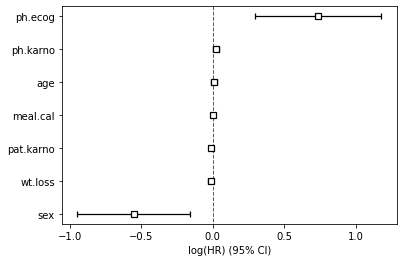

In [85]:
# Check which factor affects the most - ph.ecog and sex both have significant differences.
cph.plot();

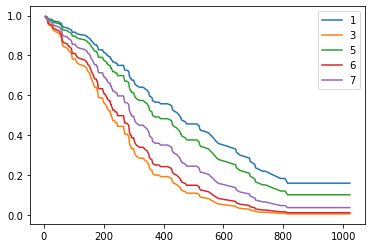

In [86]:
# Plot the graph
# This plot views 5 individuals, and their survival probability level:

d_data = data.iloc[0:5, :]
cph.predict_survival_function(d_data).plot();

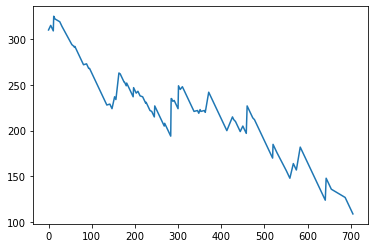

In [90]:
# Find median time until death event (I don't understand this):
CTE = kmf.conditional_time_to_event_
plt.plot(CTE);